# Illinois
## Contents
- [Imports](#Data-Dictionary)
- [Regression Modeling](#Regression-Modeling)  
- [Classification Modeling](#Classification-Modeling)  

# Imports

In [3]:
# Import the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, confusion_matrix, plot_confusion_matrix

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm  import SVR
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer, QuantileTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier 
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier

In [4]:
# Import the Texas data and sae to a dataframe.
df = pd.read_csv('../data/cleaned_engineered_il.csv')

In [5]:
# Display the first few rows of the dataframe.
df.head(2)

,county_state,total_cases,total_fatalities,death_rate,total_tests,race_pop,race_pop_hispanic_or_latino_of_any_race,race_pop_white_alone,race_pop_black_or_african_american_alone,race_pop_american_indian_and_alaska_native_alone,...,percent_race_pop_other,percent_race_pop_minority,percent_sex_age_pop_0_to_44,percent_sex_age_pop_45_to_74,percent_sex_age_pop_75_and_over,percent_sex_age_pop_0_to_64,percent_sex_age_pop_65_and_over,percent_sex_age_pop_0_to_35,percent_sex_age_pop_35_to_59,percent_sex_age_pop_60_to_84
0,"Adams County, Illinois",1862.0,19.0,0.010204,38542,66427,1021,61009,2676,178,...,0.017779,0.081563,0.541181,0.364536,0.094284,0.804763,0.195237,0.428967,0.312373,0.230117
1,"Alexander County, Illinois",120.0,1.0,0.008333,2350,6532,73,4063,2169,48,...,0.033833,0.377985,0.518830,0.403858,0.077312,0.796693,0.203307,0.417177,0.307869,0.256124


# Regression Modeling

## Explainable Model: GridSearchCV with Quantile, Ridge: 32%

In [217]:
# Assign our features to X.
X = df[[
    'percent_health_ins_noninst_pop_cov_yes',
    'percent_sex_age_pop_under_5',
    'percent_sex_age_pop_5_to_9',
    'percent_sex_age_pop_10_to_14',
    'percent_sex_age_pop_15_to_19',
    'percent_sex_age_pop_20_to_24',
    'percent_sex_age_pop_25_to_34',
    'percent_race_pop_hispanic_or_latino_of_any_race',
    'percent_race_pop_white_alone',
    'percent_race_pop_black_or_african_american_alone',
    'percent_race_pop_american_indian_and_alaska_native_alone',
    'percent_race_pop_asian_alone',
    'percent_race_pop_native_hawaiian_and_other_pacific_islander_alone',
    'percent_race_pop_some_other_race_alone',
    'percent_race_pop_two_or_more_races',
    'pop_density',
    'tests_per_100_people',    
    'percent_inc_hhlds_50_000_to_99_999',
    'obes_percent',
]]

y = df['cases_per_100_people']

# Split X and y into train/test groups.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [218]:
# Display the shape of the training data.
X_train.shape

(76, 19)

In [219]:
X_test.shape

(26, 19)

In [220]:
# Create a main pipeline that will contain the dtype pipelines and the estimator.
pipe = make_pipeline(QuantileTransformer(), Ridge(max_iter=20_000))

# Set parameters for GridSearchCV.
params = {
    'ridge__alpha': [.1, 1, 10]
}

# Set up GridSearchCV with the pipe and R2 as the scoring method.
gs = GridSearchCV(pipe, param_grid=params, scoring='r2', cv=10, n_jobs=-1)

In [221]:
# Call fit on the GridSearchCV object and pass the training  data.
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('quantiletransformer',
                                        QuantileTransformer()),
                                       ('ridge', Ridge(max_iter=20000))]),
             n_jobs=-1, param_grid={'ridge__alpha': [0.1, 1, 10]},
             scoring='r2')

In [222]:
# Display the best parameters.
gs.best_params_

{'ridge__alpha': 10}

In [223]:
# Display the score for the test set.
gs.score(X_test, y_test)

0.32213820875000243

In [224]:
# Display the score for the train set.
gs.score(X_train, y_train)

0.3273571150892365

In [225]:
# Calculate the RMSE for the model.
y_preds = gs.predict(X_test)
print('RMSE of Model:', mean_squared_error(y_test, y_preds, squared=False))

RMSE of Model: 0.4285058992575644


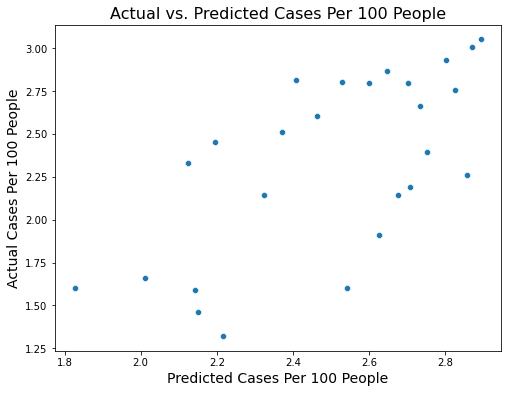

In [226]:
# Plot the predicted sale price versus the actual 'cases_per_100_people'
plt.figure(figsize=(8,6))
sns.scatterplot(y_preds, y_test)
plt.title('Actual vs. Predicted Cases Per 100 People', fontsize=16)
plt.xlabel('Predicted Cases Per 100 People', fontsize=14)
plt.ylabel('Actual Cases Per 100 People', fontsize=14);

In [227]:
features = X_train.columns

In [228]:
# Extract the coefficients for the features used in the best model.
coefs = gs.best_estimator_.named_steps['ridge'].coef_

In [229]:
coefs.shape

(19,)

In [230]:
coefs

array([-0.17591032,  0.13696218, -0.15361132,  0.19771331,  0.08145447,
        0.1011511 ,  0.35493794,  0.15535669, -0.08053971,  0.09180728,
        0.12433603, -0.0362357 , -0.08218879,  0.25546501, -0.10700708,
        0.15509018,  0.09802824, -0.02957332, -0.01465474])

In [231]:
coef_df = pd.DataFrame(list(zip(features, coefs)), columns=['Feature', 'cases_per_100_people'])
coef_df = coef_df.set_index('Feature')
coef_df = coef_df.sort_values(by='cases_per_100_people', ascending=False)

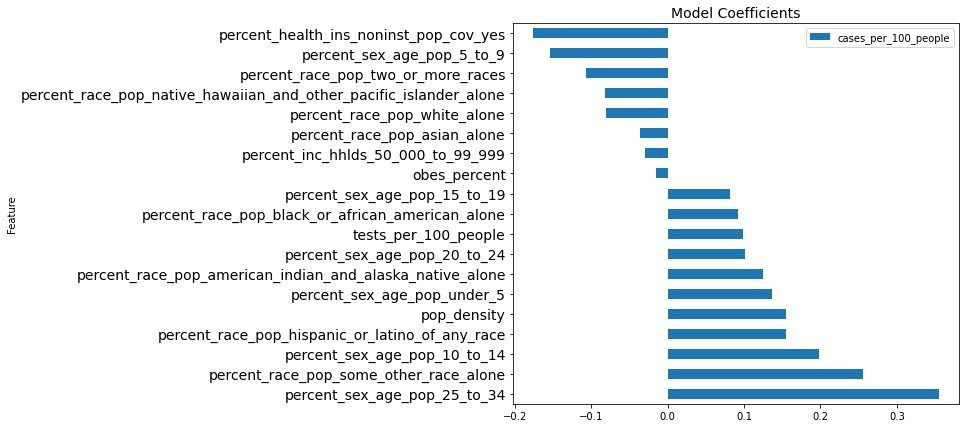

In [232]:
# Plot the datatframe of the top 10 word and their coefficients.
coef_df.plot(kind = 'barh', figsize=(8,7))
plt.title('Model Coefficients', fontsize=14)
plt.yticks(fontsize=14);

## Blackbox Model: Quantile, Polynomial, Gridsearch, Ridge: 10%

In [241]:
# Assign our features to X.
X = df[[
    'percent_health_ins_noninst_pop_cov_yes',
    'percent_sex_age_pop_under_5',
    'percent_sex_age_pop_5_to_9',
    'percent_sex_age_pop_10_to_14',
    'percent_sex_age_pop_15_to_19',
    'percent_sex_age_pop_20_to_24',
    'percent_sex_age_pop_25_to_34',
    'percent_race_pop_hispanic_or_latino_of_any_race',
    'percent_race_pop_white_alone',
    'percent_race_pop_black_or_african_american_alone',
    'percent_race_pop_american_indian_and_alaska_native_alone',
    'percent_race_pop_asian_alone',
    'percent_race_pop_native_hawaiian_and_other_pacific_islander_alone',
    'percent_race_pop_some_other_race_alone',
    'percent_race_pop_two_or_more_races',
    'pop_density',
    'tests_per_100_people',    
    'percent_inc_hhlds_50_000_to_99_999',
    'obes_percent'
]]

y = df['cases_per_100_people']

# Split X and y into train/test groups.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [242]:
# Display the shape of the training data.
X_train.shape

(76, 19)

In [242]:
# Display the shape of the test data.
X_test.shape

(76, 19)

In [243]:
# Create a main pipeline that will contain the dtype pipelines and the estimator.
pipe = make_pipeline(QuantileTransformer(), PolynomialFeatures(), SelectKBest(f_regression), Ridge(max_iter=20_000))

# Set parameters for GridSearchCV.
params = {
    'selectkbest__k': range(1,300),
    'ridge__alpha': [.1, 1, 10, 20, 30]
}

# Set up GridSearchCV with the pipe and R2 as the scoring method.
gs = GridSearchCV(pipe, param_grid=params, scoring='r2', cv=10, n_jobs=-1)

In [244]:
# Call fit on the GridSearchCV object and pass the training  data.
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('quantiletransformer',
                                        QuantileTransformer()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7f1dd1ca1d40>)),
                                       ('ridge', Ridge(max_iter=20000))]),
             n_jobs=-1,
             param_grid={'ridge__alpha': [0.1, 1, 10, 20, 30],
                         'selectkbest__k': range(1, 300)},
             scoring='r2')

In [245]:
# Display the best parameters.
gs.best_params_

{'ridge__alpha': 10, 'selectkbest__k': 4}

In [246]:
# Display the score for the test set.
gs.score(X_test, y_test)

0.10145427162091203

In [247]:
# Display the score for the train set.
gs.score(X_train, y_train)

0.24606754059547997

In [248]:
# Calculate the RMSE for the model.
y_preds = gs.predict(X_test)
print('RMSE of Model:', mean_squared_error(y_test, y_preds, squared=False))

RMSE of Model: 0.4933513486611298


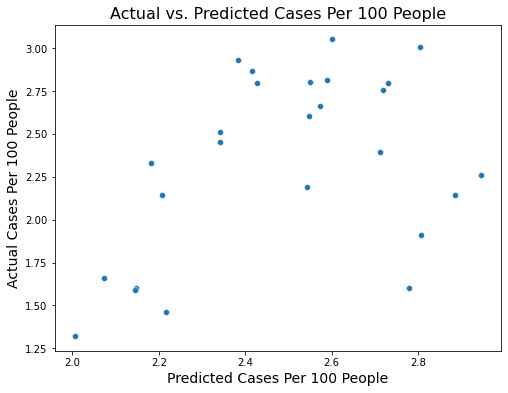

In [249]:
# Plot the predicted sale price versus the actual sale price
plt.figure(figsize=(8,6))
sns.scatterplot(y_preds, y_test)
plt.title('Actual vs. Predicted Cases Per 100 People', fontsize=16)
plt.xlabel('Predicted Cases Per 100 People', fontsize=14)
plt.ylabel('Actual Cases Per 100 People', fontsize=14);

# Classification Modeling

## Simple(r) Model: GridSearchCV with Classifier: 71% (baseline 54)

In [250]:
# Assign our features to X.
X = df[[
    'percent_health_ins_noninst_pop_cov_yes',
    'percent_sex_age_pop_under_5',
    'percent_sex_age_pop_5_to_9',
    'percent_sex_age_pop_10_to_14',
    'percent_sex_age_pop_15_to_19',
    'percent_sex_age_pop_20_to_24',
    'percent_sex_age_pop_25_to_34',
    'percent_race_pop_hispanic_or_latino_of_any_race',
    'percent_race_pop_white_alone',
    'percent_race_pop_black_or_african_american_alone',
    'percent_race_pop_american_indian_and_alaska_native_alone',
    'percent_race_pop_asian_alone',
    'percent_race_pop_native_hawaiian_and_other_pacific_islander_alone',
    'percent_race_pop_some_other_race_alone',
    'percent_race_pop_two_or_more_races',
    'pop_density',
    'tests_per_100_people',    
    'percent_inc_hhlds_50_000_to_99_999',
    'obes_percent',
]]

y = df['covid_severity']

# Split X and y into train/test groups.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [253]:
y_test.value_counts(normalize=True)

2    0.538462
1    0.307692
3    0.153846
Name: covid_severity, dtype: float64

In [254]:
# Display the shape of the training data.
X_train.shape

(76, 19)

In [255]:
X_test.shape

(26, 19)

In [256]:
# Create a main pipeline that will contain the dtype pipelines and the estimator.
pipe = make_pipeline(QuantileTransformer(), SelectKBest(), LogisticRegression())

# Set parameters for GridSearchCV.
params = {
    'selectkbest__k': range(1,21),
    'logisticregression__C': [.1, .5, 1, 10]
}

# Set up GridSearchCV with the pipe and R2 as the scoring method.
gs = GridSearchCV(pipe, param_grid=params, cv=10, n_jobs=-1)

In [257]:
# Call fit on the GridSearchCV object and pass the training  data.
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('quantiletransformer',
                                        QuantileTransformer()),
                                       ('selectkbest', SelectKBest()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.1, 0.5, 1, 10],
                         'selectkbest__k': range(1, 21)})

In [258]:
# Display the best parameters.
gs.best_params_

{'logisticregression__C': 0.5, 'selectkbest__k': 9}

In [259]:
# Display the score for the test set.
gs.score(X_test, y_test)

0.7307692307692307

In [261]:
# Display the score for the train set.
gs.score(X_train, y_train)

0.6710526315789473

In [262]:
y_preds = gs.predict(X_test)

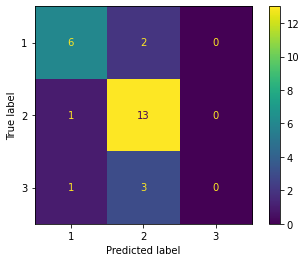

In [264]:
# Plot the predicted sale price versus the actual sale price
plot_confusion_matrix(gs, X_test, y_test);

In [265]:
# Extract a boolean matrix of features selectkbest used in the best model.
features = gs.best_estimator_.named_steps['selectkbest'].get_support()
features

array([False, False, False, False, False,  True,  True,  True,  True,
        True,  True, False, False,  True, False,  True, False,  True,
       False])

In [266]:
features = X_train.columns[features==True]

In [267]:
# Extract the coefficients for the features used in the best model.
coefs = gs.best_estimator_.named_steps['logisticregression'].coef_

In [268]:
coefs.shape

(3, 9)

In [269]:
coef1 = coefs[0]
coef2 = coefs[1]
coef3 = coefs[2]

In [270]:
pd.DataFrame(list(zip(features, coef1)), columns=['Feature', 'covid_severity_1'])

,Feature,covid_severity_1
0,percent_sex_age_pop_20_to_24,-0.703966
1,percent_sex_age_pop_25_to_34,-0.634454
2,percent_race_pop_hispanic_or_latino_of_any_race,-0.109781
3,percent_race_pop_white_alone,0.116631
4,percent_race_pop_black_or_african_american_alone,-0.165603
5,percent_race_pop_american_indian_and_alaska_na...,-0.848127
6,percent_race_pop_some_other_race_alone,-0.635831
7,pop_density,-0.660758
8,percent_inc_hhlds_50_000_to_99_999,0.612596


In [271]:
pd.DataFrame(list(zip(features, coef2)), columns=['Feature', 'covid_severity_2'])

,Feature,covid_severity_2
0,percent_sex_age_pop_20_to_24,0.566736
1,percent_sex_age_pop_25_to_34,-0.076349
2,percent_race_pop_hispanic_or_latino_of_any_race,-0.298248
3,percent_race_pop_white_alone,0.192909
4,percent_race_pop_black_or_african_american_alone,-0.014821
5,percent_race_pop_american_indian_and_alaska_na...,0.564291
6,percent_race_pop_some_other_race_alone,0.539686
7,pop_density,0.445587
8,percent_inc_hhlds_50_000_to_99_999,-0.401640


In [272]:
pd.DataFrame(list(zip(features, coef3)), columns=['Feature', 'covid_severity_3'])

,Feature,covid_severity_3
0,percent_sex_age_pop_20_to_24,0.137231
1,percent_sex_age_pop_25_to_34,0.710804
2,percent_race_pop_hispanic_or_latino_of_any_race,0.408029
3,percent_race_pop_white_alone,-0.309540
4,percent_race_pop_black_or_african_american_alone,0.180423
5,percent_race_pop_american_indian_and_alaska_na...,0.283836
6,percent_race_pop_some_other_race_alone,0.096144
7,pop_density,0.215171
8,percent_inc_hhlds_50_000_to_99_999,-0.210956


## Blackbox Model: Quantile, Polynomial, Gridsearch, Classifier: 65% (baseline 54)

In [274]:
# Assign our features to X.
X = df[[
    'percent_health_ins_noninst_pop_cov_yes',
    'percent_sex_age_pop_under_5',
    'percent_sex_age_pop_5_to_9',
    'percent_sex_age_pop_10_to_14',
    'percent_sex_age_pop_15_to_19',
    'percent_sex_age_pop_20_to_24',
    'percent_sex_age_pop_25_to_34',
    'percent_race_pop_hispanic_or_latino_of_any_race',
    'percent_race_pop_white_alone',
    'percent_race_pop_black_or_african_american_alone',
    'percent_race_pop_american_indian_and_alaska_native_alone',
    'percent_race_pop_asian_alone',
    'percent_race_pop_native_hawaiian_and_other_pacific_islander_alone',
    'percent_race_pop_some_other_race_alone',
    'percent_race_pop_two_or_more_races',
    'pop_density',
    'tests_per_100_people',    
    'percent_inc_hhlds_50_000_to_99_999',
    'obes_percent',
]]

y = df['covid_severity']

# Split X and y into train/test groups.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [275]:
# Display the shape of the training data.
X_train.shape

(76, 19)

In [276]:
# Display the shape of the training data.
X_test.shape

(26, 19)

In [277]:
# Create a main pipeline that will contain the dtype pipelines and the estimator.
pipe = make_pipeline(QuantileTransformer(), PolynomialFeatures(), SelectKBest(), LogisticRegression())

# Set parameters for GridSearchCV.
params = {
    'selectkbest__k': range(1,300),
    'logisticregression__C': [.1, .5, 1, 10]
}

# Set up GridSearchCV with the pipe and R2 as the scoring method.
gs = GridSearchCV(pipe, param_grid=params, cv=10, n_jobs=-1)

In [278]:
# Call fit on the GridSearchCV object and pass the training  data.
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('quantiletransformer',
                                        QuantileTransformer()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('selectkbest', SelectKBest()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.1, 0.5, 1, 10],
                         'selectkbest__k': range(1, 300)})

In [279]:
# Display the best parameters.
gs.best_params_

{'logisticregression__C': 10, 'selectkbest__k': 5}

In [280]:
# Display the score for the test set.
gs.score(X_test, y_test)

0.6538461538461539

In [281]:
# Display the score for the train set.
gs.score(X_train, y_train)

0.7105263157894737

In [282]:
y_preds = gs.predict(X_test)

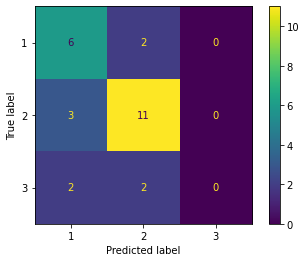

In [284]:
# Plot the predicted label versus the actual label.
plot_confusion_matrix(gs, X_test, y_test);